# MAT 186 Code Demo: Accuracy of Numerical Integration Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson, quad

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

In this demo, we study various approximations of the definite integral 
$$
A = \int_{-1}^{+1} \frac{\mathrm{d}x}{1+x^2} . 
$$
One can use the Fundamental Theorem of Calculus to show that 
$$
A = \frac{\pi}{2},
$$
so we have an exact answer to compare our approximations to! Comparing approximations against a known standard is a great way to assess the quality of a numerical method. 

The numerical approximation of integrals is also known as **quadrature**. We study four different quadrature strategies for approximating $A$:

1) a *left*-endpoint Riemann sum approximation with constant subinterval size,

2) a *right*-endpoint Riemann sum approximation with constant subinterval size,

3) an approximation via **Simpson's Rule**, and 

4) an approximation via a **Gauss-Legendre Rule**.

I expect you know the details of the left- and right-endpoint Riemann sum approximations, but Simpson and Gauss-Legendre may be unfamiliar to you. However, for the purposes of this demo, the details are unimportant: what is important is seeing that these methods allow us to approximate $A$ much better than the left/right-endpoint schemes!

First, we define our integrand $f(x)=\left(1+x^2\right)^{-1}$ as a Python callable function:

In [2]:
def f(x): 
    return (1.+x**2)**-1

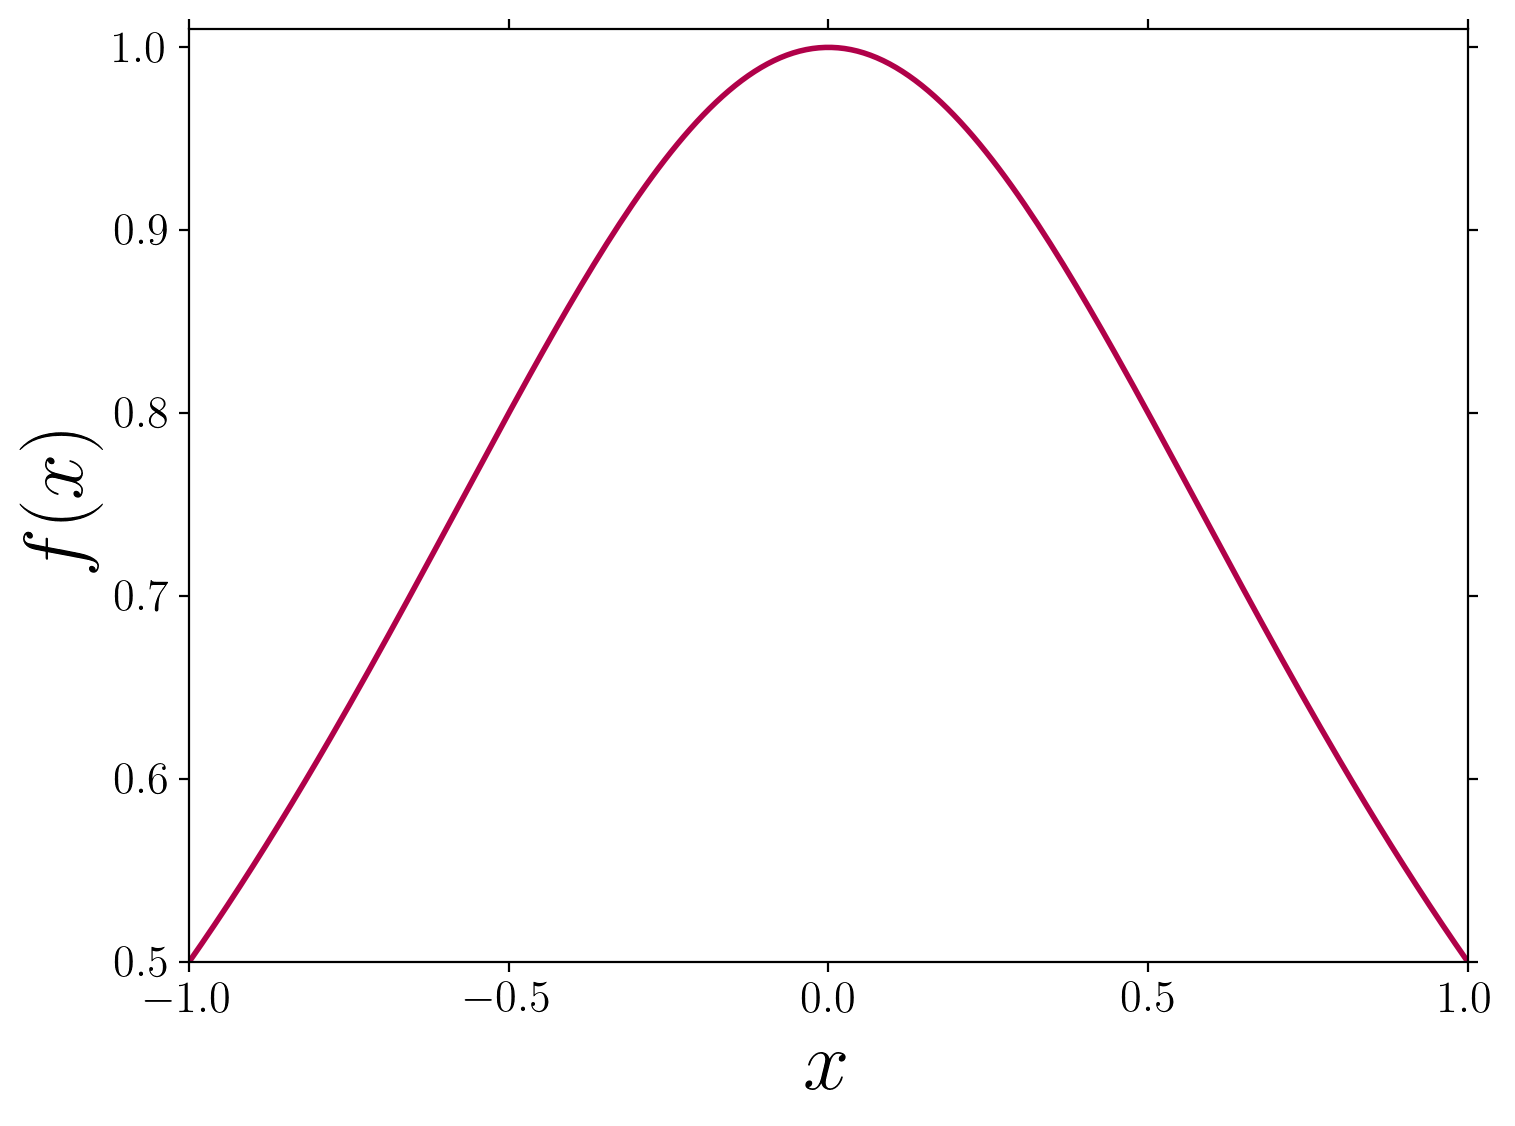

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax =plt.subplots()

x = np.linspace(-1,1, 200)
plt.plot(x, f(x), linestyle='solid', color='xkcd:raspberry', linewidth='2')

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = 'k'

plt.xlim([-1.,1.])
plt.ylim([0.5,1.01])

plt.xlabel(r"$x$", fontsize=30, color = 'k')
plt.ylabel(r"$f(x)$", fontsize=30, color = 'k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='x', nbins=6)

plt.tight_layout()

fig.set_size_inches(8, 6)
plt.savefig('int_demo_f' + '.jpg', dpi=700)
plt.show()

From the plot of $f(x)$ above, we see it is a very nice function. 

The next code box consists of a script for Gauss-Legendre quadrature, based on code and exercises from the excellent book *Numerical Linear Algebra* by Trefethen and Bau (for the Simpson rule, we just use the built-in SciPy function $\texttt{simpson}$). You don't have to understand any of this code, or why eigenvalues have anything to do with numerical integration: my point in including it is just to show you that a few lines of clever code can give you an amazing numerical method. 

In [4]:
# define a function that computes the weights and nodes (on [-1,1]) of 
# the Gauss-Legendre quadrature for a given number of nodes n
def GL(n):
    # initializes nodes
    x = np.zeros(n)
    
    # initialize weights
    w = np.zeros(n)
    
    # define the Jacobi matrix. Remember that the diagonals are all
    # zero when the usual measure dx is used to compute the integrals.
    beta=np.zeros(n-1)
    
    for i in np.arange(0,n-1):
        
        beta[i] = 0.5*(1.-(2.*(i+1))**(-2.))**(-0.5) # careful with the indexing!
    
    T= np.diag(beta, -1) + np.diag(beta, 1)

# find spectral decomposition of Jacobi matrix using built-in routine. 
# We use np.linalg.eigh which is specialized to work on symmetric matrices
    x, V = np.linalg.eigh(T)
    
    w = 2.*(V[0, :])**2
    
    return x, w

# define a function that calls GL(n) to produce an estimate of
# the integral of f over [-1,1] using the n-point Gauss-Legendre quadrature.

def GLquad(f, n):
    
    x, w = GL(n) # extract weights and nodes for the given number of points
    
    integral = np.sum(w*f(x)) # compute quadrature with handy entrywise mult. and array sum func.
    
    return integral

Now, we test out our four approximation schemes for various numbers of sample points (num. representative sample points = num. subintervals +1). 

In [16]:
A_true = np.pi/2

Nmin = 4
Nmax = 25

n_data = np.arange(Nmin, Nmax+1)

El = np.zeros_like(n_data, dtype=float)
Er = np.copy(El)
E_simps = np.copy(El)
E_GL = np.copy(El)

for n in n_data:
    # left Riemann
    xl = np.linspace(-1,1, n, endpoint =False)
    Al = (2./(n-1))*np.sum(f(xl))

    # right Riemann
    xr = np.linspace(-1+2./(n-1),1, n, endpoint =True)
    Ar = (2./(n-1))*np.sum(f(xr))
    
    # Simpson
    # have to do a little fiddling because Simpson likes to have 
    # an even # of subintervals (iff odd # of sample pts)
    if n%2 == 0:
        ns = n-1
    else: 
        ns = n
        
    xs = np.linspace(-1, 1, ns, endpoint=True)
    A_simps = simpson(f(xs), xs)
    
    # Gauss-Legendre
    A_GL = GLquad(f, n)

    m = n - Nmin
    El[m] = np.abs(Al-A_true)/A_true
    Er[m] = np.abs(Ar-A_true)/A_true
    E_simps[m] = np.abs(A_simps-A_true)/A_true
    E_GL[m] = np.abs(A_GL-A_true)/A_true

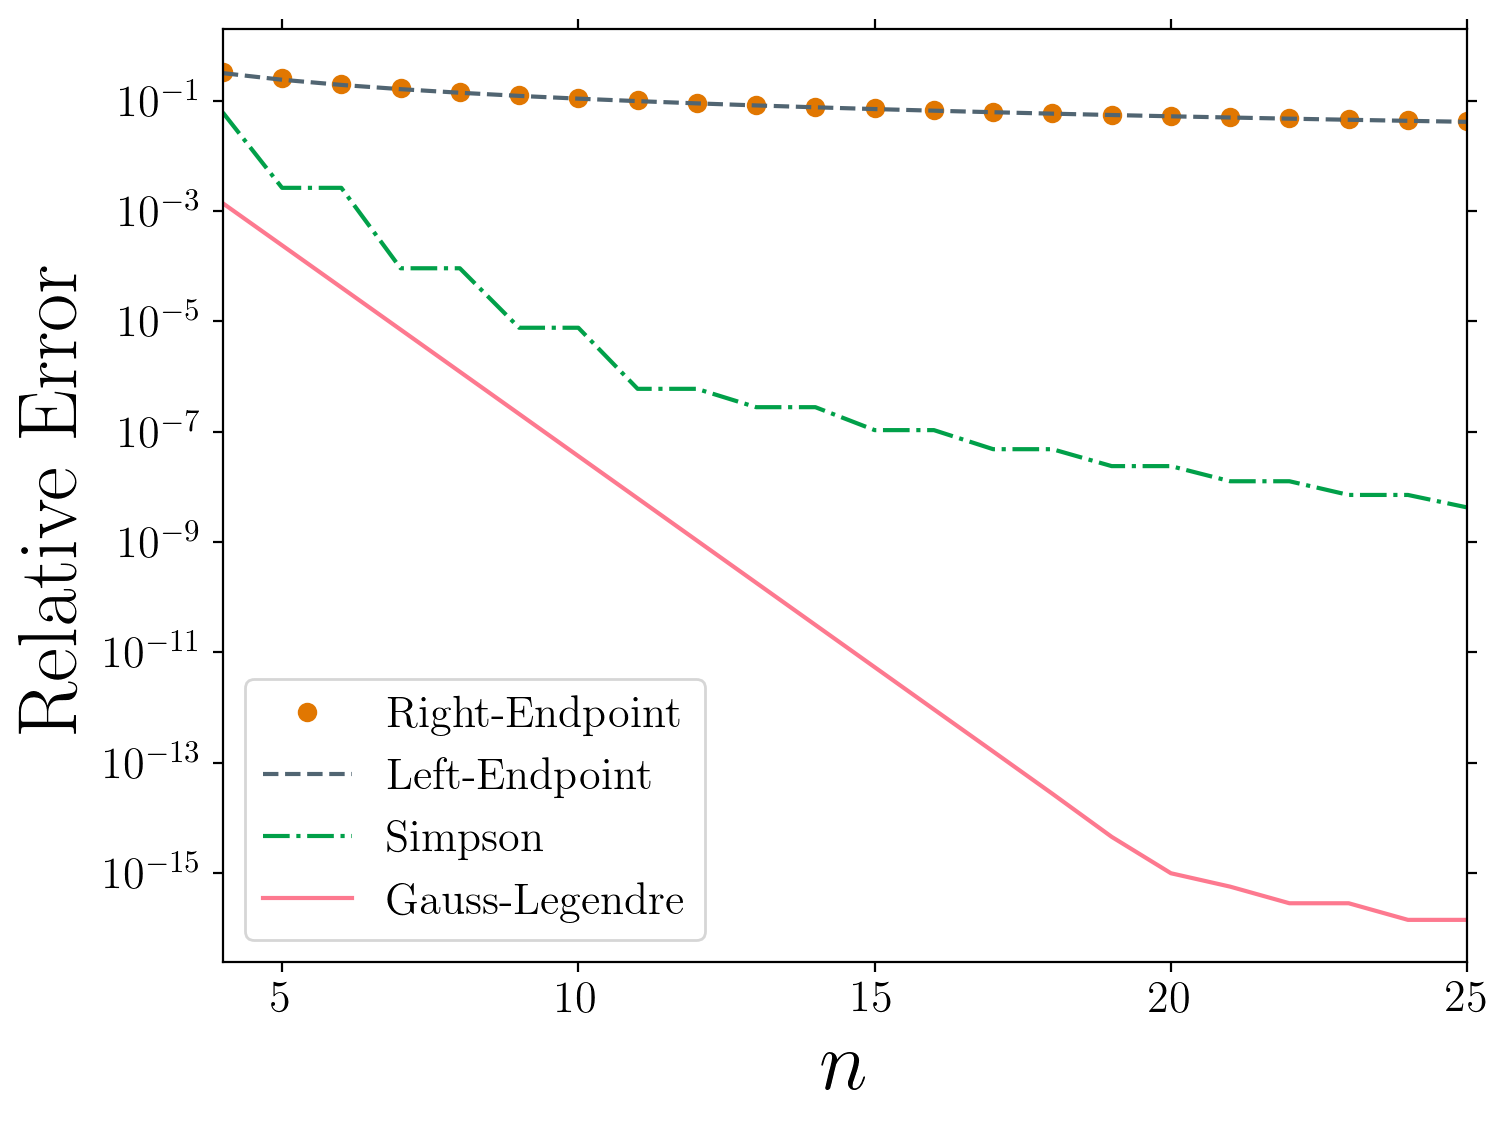

In [6]:
fig, ax =plt.subplots()

plt.semilogy(n_data, Er, 'o', label='Right-Endpoint', color='xkcd:pumpkin', linewidth=1.5)
plt.semilogy(n_data, El, label='Left-Endpoint', color='xkcd:slate', linestyle='dashed', linewidth=1.5)
plt.semilogy(n_data, E_simps, label='Simpson', color='xkcd:emerald', linestyle='dashdot', linewidth=1.5)
plt.semilogy(n_data, E_GL, label='Gauss-Legendre', color='xkcd:carnation', linestyle='solid', linewidth=1.5)

plt.legend(fontsize='16')

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = 'k'

plt.xlim([Nmin,Nmax])
#plt.ylim([0.9*y0, 1.1*x0])

plt.xlabel(r"$n$", fontsize=30, color = 'k')
plt.ylabel(r"Relative Error", fontsize=30, color = 'k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='x', nbins=6)

plt.tight_layout()

fig.set_size_inches(8, 6)
plt.savefig('int_errors_semilogy' + '.jpg', dpi=700)

#"""
plt.show()

The vanilla left/right Riemann sums give us a few decimal places, and Simpson's rule gives a solid improvement. However, the clear winner here is Gauss-Legendre quadrature: this produces a machine-accurate answer when only 25 sample points are used!

Gauss-Legendre does such a great job compared to the other methods that we should investigate our left/right-endpoint approximations for much larger $n$ to make sure the approximation actually converges and there's not a bug in our code! 

WARNING: The next two code boxes can take a little bit of time to run, so please be patient :)

In [14]:
Nmin_new = 4
Nmax_new = int(1e6)

shift = 2000
n_data_new = np.arange(Nmin_new, Nmax_new+1)[::shift]

El_new = np.zeros_like(n_data_new, dtype=float)
Er_new = np.copy(El_new)
E_simps_new = np.copy(El_new)

for n in n_data_new:
   # left Riemann
    xl = np.linspace(-1,1, n, endpoint =False)
    Al = (2./(n-1))*np.sum(f(xl))

    # right Riemann
    xr = np.linspace(-1+2./(n-1),1, n, endpoint =True)
    Ar = (2./(n-1))*np.sum(f(xr))
    
    """ # Can put in Simpson if you want to
     # Simpson
    if n%2 == 0:
        ns = n-1
    else: 
        ns = n
        
    xs = np.linspace(-1, 1, ns, endpoint=True)
    A_simps = simpson(f(xs), xs)
    """

    m = int((n - Nmin_new)/shift)
    El_new[m] = np.abs(Al-A_true)/A_true
    Er_new[m] = np.abs(Ar-A_true)/A_true
    #E_simps_new[m] = np.abs(A_simps-A_true)/A_true

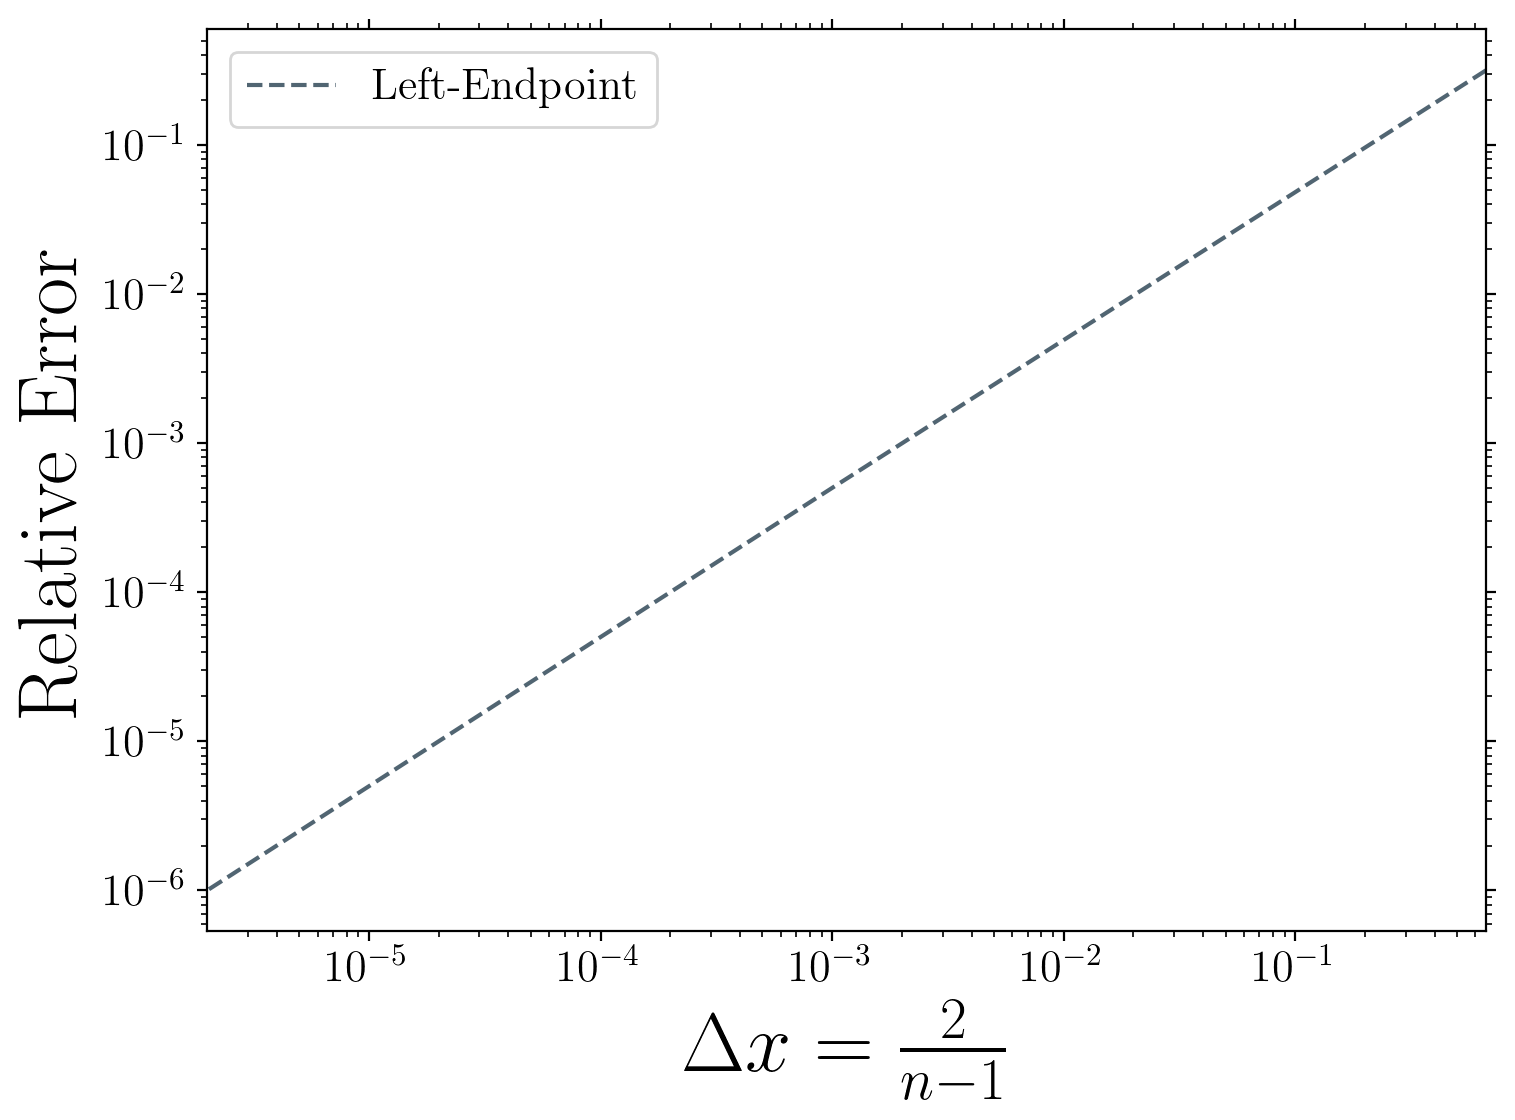

In [15]:
fig, ax =plt.subplots()

dx = 2./(n_data_new-1.)

#plt.semilogy(dx[0::4], Er_new[0::4], 'o', label='Right-Endpoint', color='xkcd:pumpkin', linewidth=1.5)
plt.loglog(dx, El_new, label='Left-Endpoint',color='xkcd:slate', linestyle='dashed', linewidth=1.5)
# again, you can put in Simpson if you want to 
#plt.loglog(dx, E_simps_new, label='Simpson', color='xkcd:emerald', linestyle='dashdot', linewidth=1.5)

plt.legend(fontsize='16')

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = 'k'

plt.xlim([np.amin(dx), np.amax(dx)])
#plt.ylim([0.9*y0, 1.1*x0])

plt.xlabel(r"$\Delta x = \frac{2}{n-1}$", fontsize=30, color = 'k')
plt.ylabel(r"Relative Error", fontsize=30, color = 'k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')

plt.tight_layout()

fig.set_size_inches(8, 6)
plt.savefig('int_errors_loglog' + '.jpg', dpi=700)

#"""
plt.show()

I have chosen not to plot the right-endpoint approximation because it is essentially identical to the left-endpoint one here. This picture indicates that our approximations indeed converge, albeit quite slowly (especially compared to Gauss-Legendre). 

We can check the slope of the error line in the above plot using a line of best fit: 

In [9]:
slope= np.polyfit(np.log(dx), np.log(Er_new), 1)[0]
print(slope)

1.0001454073025313


From this computation, we may reasonably conjecture that the error in a left/endpoint Riemann sum approximation of $A$ with a subinterval width of $\Delta x$ is *directly proportional to $\Delta x$*. 

Of course, if you're numerically integrating "out in the wild" and don't want to build your own quadrature code from scratch, it's a good idea to go with the built-in adaptive routine for whatever language you're using. For SciPy, this routine is $\texttt{quad}$: 

In [10]:
A_quad = quad(f, -1, 1)[0]
E_quad = np.abs(A_quad-A_true)/(A_true)
print('Relative Error for SciPy quad integrator= ', E_quad)

Relative Error for SciPy quad integrator=  1.4135798584282297e-16


We see that $\texttt{quad}$ gives us a machine-accurate answer (like Gauss-Legendre) while keeping all algorithmic details under the hood. SciPy also features built-in Gauss and adaptive Gauss quadrature. 

In summary, there are lots of different ways to numerically approximate integrals. Though Riemann sum approximations is conceptually very clear and quite useful when it comes to model derivation, such approximations tend to converge quite slowly. When it comes to actually getting a usable numerical approximation of an integral, a more sophisticated quadrature method such as Simpson's rule, a Gauss-Legendre method, or adaptive quadrature should be applied. 